In [1]:
from google.colab import drive
drive.mount('/content/drive')


ModuleNotFoundError: No module named 'google.colab'

In [ ]:
requirements_path = '/content/drive/MyDrive/DL_Trump_Files/requirements.txt'
!pip install -r {requirements_path}

  Using cached blinker-1.8.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached flask-3.0.3-py3-none-any.whl.metadata (3.2 kB)
  Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl.metadata (572 bytes)
  Using cached werkzeug-3.0.3-py3-none-any.whl.metadata (3.7 kB)
Using cached blinker-1.8.2-py3-none-any.whl (9.5 kB)
Using cached flask-3.0.3-py3-none-any.whl (101 kB)
Using cached vaderSentiment-3.3.2-py2.py3-none-any.whl (125 kB)
Using cached werkzeug-3.0.3-py3-none-any.whl (227 kB)
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.0.4
    Uninstalling Werkzeug-3.0.4:
      Successfully uninstalled Werkzeug-3.0.4
  Attempting uninstall: blinker
    Found existing installation: blinker 1.4
error: uninstall-distutils-installed-package

× Cannot uninstall blinker 1.4
╰─> It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [2]:
model_path = '/content/drive/MyDrive/DL_Trump_Files/pretrained_trump_model/'

In [3]:
import torch
print(torch.cuda.is_available())  # True if a GPU is available
print(torch.cuda.device_count())  # how many GPUs are available

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
1


# Load tokenizer and model

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import transformers
import logging

# Disable some warnings by setting logging level
transformers.logging.set_verbosity_error()

tokenizer = AutoTokenizer.from_pretrained(model_path)
# Set the model to output a single regression value for each input
model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=1,  # This is for regression
    ignore_mismatched_sizes=True  # Ignore the classifier size mismatch
).to(device)



In [6]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119577, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


# Load your training data

In [44]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/DL_Trump_Files/trump_train_final.csv")
df_test= pd.read_csv("/content/drive/MyDrive/DL_Trump_Files/test_trump_final.csv")
num_samples = len(df)

# Get best batch size

In [8]:
import time

# Function to time how long it takes to process with each batch size
def time_model_with_batch_size(model, tokenizer, dataset, batch_size):
    model.to(device)
    start_time = time.time()

    # Tokenize the dataset in batches
    for i in range(0, len(dataset), batch_size):
        batch_texts = dataset[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(device)

        # Perform a forward pass through the model
        with torch.no_grad():
            outputs = model(**inputs)

    end_time = time.time()
    print(f"Batch size: {batch_size} | Time: {end_time - start_time:.2f} seconds")

reviews_list = df['article'].tolist()

# Define different batch sizes to test
batch_sizes = [1, 2, 4, 8, 16, 32, 64, 100 ,200, num_samples]

# Test each batch size
for batch_size in batch_sizes:
    print(f"Testing with batch size: {batch_size}")
    time_model_with_batch_size(model, tokenizer, reviews_list, batch_size)


Testing with batch size: 1
Batch size: 1 | Time: 3.00 seconds
Testing with batch size: 2
Batch size: 2 | Time: 0.97 seconds
Testing with batch size: 4
Batch size: 4 | Time: 0.57 seconds
Testing with batch size: 8
Batch size: 8 | Time: 0.50 seconds
Testing with batch size: 16
Batch size: 16 | Time: 0.48 seconds
Testing with batch size: 32
Batch size: 32 | Time: 0.50 seconds
Testing with batch size: 64
Batch size: 64 | Time: 0.49 seconds
Testing with batch size: 100
Batch size: 100 | Time: 0.51 seconds
Testing with batch size: 200
Batch size: 200 | Time: 0.38 seconds
Testing with batch size: 325
Batch size: 325 | Time: 0.18 seconds


In [9]:
# For Memory and decent speed use 8
batch_size_best = 8

In [10]:
# Tokenize to check article length in tokens
token_lengths = [len(tokenizer(article)['input_ids']) for article in df['article']]
max(token_lengths)

72

#Train-test split

In [12]:
from sklearn.model_selection import train_test_split

# Split the data into 90% training and 10% validation
train_df, val_df = train_test_split(df, test_size=0.1, random_state=0)

# Get the labels for training and validation sets
train_labels = train_df['score'].tolist()
val_labels = val_df['score'].tolist()

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Training labels size: {len(train_labels)}")
print(f"Validation labels size: {len(val_labels)}")

Training set size: 292
Validation set size: 33
Training labels size: 292
Validation labels size: 33


In [13]:
# Tokenize the training set
inputs_train = tokenizer(
    train_df['article'].tolist(),
    max_length=128,
    padding=True,
    truncation=True,
    return_tensors="pt"
)

# Tokenize the validation set
inputs_val = tokenizer(
    val_df['article'].tolist(),
    max_length=128,
    padding=True,
    truncation=True,
    return_tensors="pt"
)


# Input for model

In [14]:
from torch.utils.data import Dataset, DataLoader

class ArticleDataset(Dataset):
    def __init__(self, inputs_train, train_labels):
        self.inputs = inputs_train
        self.labels = train_labels

    def __len__(self):
        return len(self.labels)  # The length of the dataset

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs['input_ids'][idx],
            'attention_mask': self.inputs['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)  # Ensure labels are tensors
        }

# Assuming your scores are the labels you want to predict
labels = df['score'].tolist()

# Create the dataset
train_dataset = ArticleDataset(inputs_train, train_labels)
val_dataset = ArticleDataset(inputs_val, val_labels)

# Create the DataLoader
batch_size = batch_size_best
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Shuffel to prevent overfitting
val_dataloader = DataLoader(val_dataset, batch_size=batch_size) # Don't shuffel


# Apply basic layer freezing since we have a small dataset

In [15]:
# Don't Freeze embeddings
for param in model.distilbert.embeddings.parameters():
    param.requires_grad = True

for layer in model.distilbert.transformer.layer[:4]:  # This will freeze layers 0 to 3
    for param in layer.parameters():
        param.requires_grad = False

# Trainable layers (higher transformer blocks and classifier layers)
for param in model.pre_classifier.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True


# Early stoppage

In [16]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


# Reset model with basic freezing (used if we have to retrain the model)

In [17]:
import random
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to reset the model, set a random seed, and freeze specific layers

#Change to your local path
def reset_model_and_seed(model_path='/content/drive/MyDrive/DL_Trump_Files/pretrained_trump_model/', seed=0):
    # Set the seed for reproducibility
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Reload the pre-trained model from the provided path
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        num_labels=1,  # This is for regression
        ignore_mismatched_sizes=True  # Ignore the classifier size mismatch
    ).to(device)

    # Freezing layers

    for param in model.distilbert.embeddings.parameters():
        param.requires_grad = True  # Leave embeddings trainable

    # Freeze the first 4 transformer layers (layers 0 to 3)
    for layer in model.distilbert.transformer.layer[:4]:
        for param in layer.parameters():
            param.requires_grad = False

    # Make sure higher layers (5 and above) are trainable
    for param in model.distilbert.transformer.layer[4:].parameters():
        param.requires_grad = True

    # Ensure the pre-classifier and classifier layers are trainable
    for param in model.pre_classifier.parameters():
        param.requires_grad = True

    for param in model.classifier.parameters():
        param.requires_grad = True

    return model


# Get best number of Epochs

Epoch 1, Train Loss: 0.3221835550424215, Validation Loss: 0.2911547780036926
Epoch 2, Train Loss: 0.255921866039972, Validation Loss: 0.27803908213973044
Epoch 3, Train Loss: 0.20425202677378784, Validation Loss: 0.26279982924461365
Epoch 4, Train Loss: 0.18374609232351585, Validation Loss: 0.27728589847683904
Epoch 5, Train Loss: 0.1613279299156086, Validation Loss: 0.2704495227895677
Epoch 6, Train Loss: 0.14302897453308105, Validation Loss: 0.2614553149789572
Epoch 7, Train Loss: 0.11479120006835139, Validation Loss: 0.27352446051146445
Epoch 8, Train Loss: 0.10498285172758876, Validation Loss: 0.25335957342758775
Epoch 9, Train Loss: 0.093451581140225, Validation Loss: 0.2667168230487732
Epoch 10, Train Loss: 0.08652300644363906, Validation Loss: 0.2686359939572867
Epoch 11, Train Loss: 0.06958230740919306, Validation Loss: 0.25723691324237735
Epoch 12, Train Loss: 0.07042424969777868, Validation Loss: 0.24775218777358532
Epoch 13, Train Loss: 0.056377725877069136, Validation Loss:

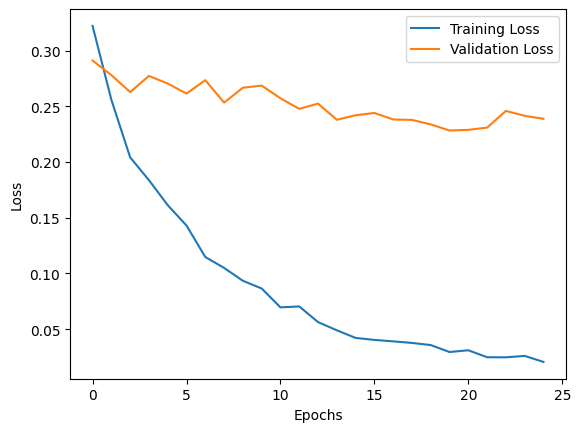

In [18]:
from torch.optim import AdamW
from torch.nn import MSELoss
import matplotlib.pyplot as plt

# Start with AdamW since it's best for transformers
# Use MSELoss since we are doing regression-based sentiment analysis
# Use a general learning rate

def train_model(model, train_dataloader, val_dataloader, num_epochs=10, patience=5, optimizer_func=AdamW, learning_rate=1e-5, loss_func=MSELoss):
    # Set optimizer and loss function
    optimizer = optimizer_func(model.parameters(), lr=learning_rate)
    criterion = loss_func()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience)

    # Lists to track losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)  # Ensure the right shape for regression

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Average training loss
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

        # Check for early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Return the training and validation losses so they can be plotted outside
    return train_losses, val_losses

# Reset the model before training
model = reset_model_and_seed()

# Call the train_model function and store the returned losses
train_losses, val_losses = train_model(
    model,
    train_dataloader,
    val_dataloader,
    num_epochs=50,  # Set this to a larger value, use early stopping to get the best actual number of epochs
    patience=5,
    optimizer_func=AdamW,
    learning_rate=1e-5,
    loss_func=MSELoss
)

# Plot the training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [19]:
# Based on this pattern, the optimal number of epochs appears to be around 8-10 epochs.
best_epochs = 10
patience = 5

# Train initial model (after best Epochs)

Epoch 1, Train Loss: 0.3221835550424215, Validation Loss: 0.2911547780036926
Epoch 2, Train Loss: 0.255921866039972, Validation Loss: 0.27803908213973044
Epoch 3, Train Loss: 0.20425202677378784, Validation Loss: 0.26279982924461365
Epoch 4, Train Loss: 0.18374609232351585, Validation Loss: 0.27728589847683904
Epoch 5, Train Loss: 0.1613279299156086, Validation Loss: 0.2704495227895677
Epoch 6, Train Loss: 0.14302897453308105, Validation Loss: 0.2614553149789572
Epoch 7, Train Loss: 0.11479120006835139, Validation Loss: 0.27352446051146445
Epoch 8, Train Loss: 0.10498285172758876, Validation Loss: 0.25335957342758775
Epoch 9, Train Loss: 0.093451581140225, Validation Loss: 0.2667168230487732
Epoch 10, Train Loss: 0.08652300644363906, Validation Loss: 0.2686359939572867


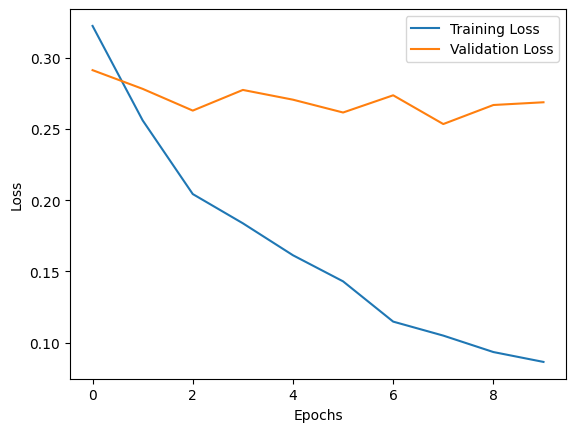

In [20]:
# Reset the model before training
model = reset_model_and_seed()

# Call the train_model function and store the returned losses
train_losses, val_losses = train_model(
    model,
    train_dataloader,
    val_dataloader,
    num_epochs=10,  # Set this to a larger value, use early stopping to get the best actual number of epochs
    patience=5,
    optimizer_func=AdamW,
    learning_rate=1e-5,
    loss_func=MSELoss
)

# Plot the training and validation losses
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

The model is overfitting since only the training loss seems to be decreasing with a reasonable amount.

# Trying to fix overfitting by increasing dropout


--- Starting Training for Ffn Dropout 0.1 ---

Epoch 1, Train Loss: 0.3221835550424215, Validation Loss: 0.2911547780036926
Epoch 2, Train Loss: 0.255921866039972, Validation Loss: 0.27803908213973044
Epoch 3, Train Loss: 0.20425202677378784, Validation Loss: 0.26279982924461365
Epoch 4, Train Loss: 0.18374609232351585, Validation Loss: 0.27728589847683904
Epoch 5, Train Loss: 0.1613279299156086, Validation Loss: 0.2704495227895677
Epoch 6, Train Loss: 0.14302897453308105, Validation Loss: 0.2614553149789572
Epoch 7, Train Loss: 0.11479120006835139, Validation Loss: 0.27352446051146445
Epoch 8, Train Loss: 0.10498285172758876, Validation Loss: 0.25335957342758775
Epoch 9, Train Loss: 0.093451581140225, Validation Loss: 0.2667168230487732
Epoch 10, Train Loss: 0.08652300644363906, Validation Loss: 0.2686359939572867

--- Starting Training for Ffn Dropout 0.2 ---

Epoch 1, Train Loss: 0.3221835550424215, Validation Loss: 0.2911547780036926
Epoch 2, Train Loss: 0.255921866039972, Validat

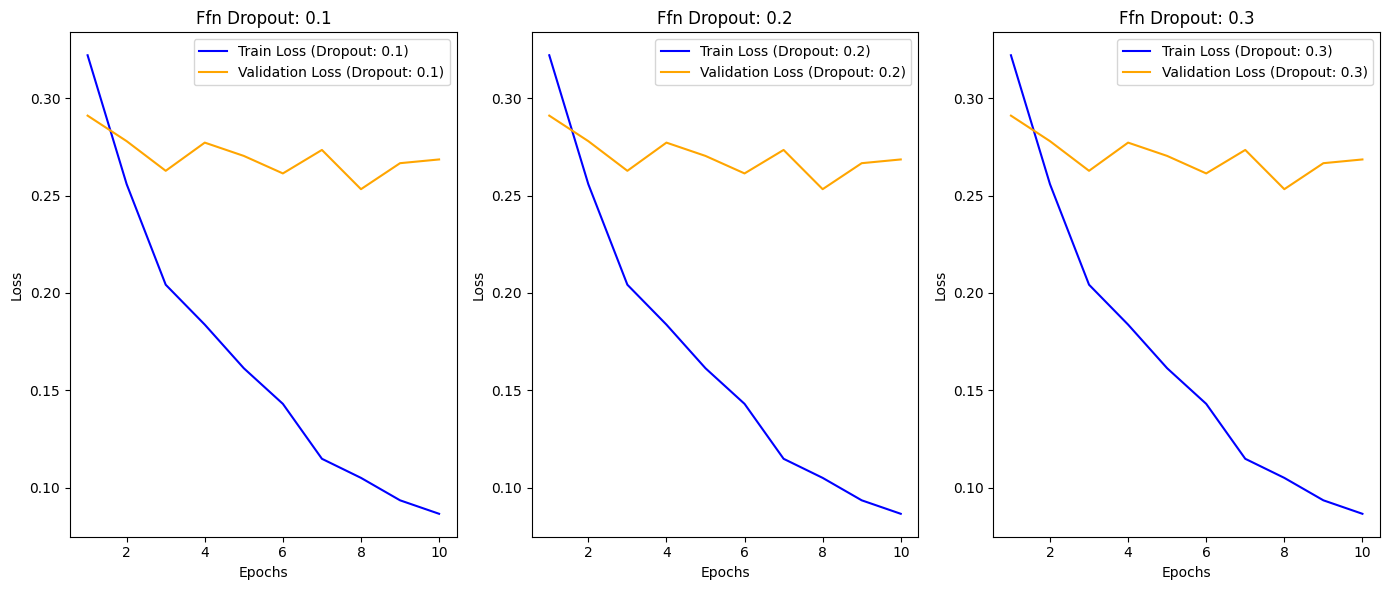


--- Starting Training for Attention Dropout 0.1 ---

Epoch 1, Train Loss: 0.3221835550424215, Validation Loss: 0.2911547780036926
Epoch 2, Train Loss: 0.255921866039972, Validation Loss: 0.27803908213973044
Epoch 3, Train Loss: 0.20425202677378784, Validation Loss: 0.26279982924461365
Epoch 4, Train Loss: 0.18374609232351585, Validation Loss: 0.27728589847683904
Epoch 5, Train Loss: 0.1613279299156086, Validation Loss: 0.2704495227895677
Epoch 6, Train Loss: 0.14302897453308105, Validation Loss: 0.2614553149789572
Epoch 7, Train Loss: 0.11479120006835139, Validation Loss: 0.27352446051146445
Epoch 8, Train Loss: 0.10498285172758876, Validation Loss: 0.25335957342758775
Epoch 9, Train Loss: 0.093451581140225, Validation Loss: 0.2667168230487732
Epoch 10, Train Loss: 0.08652300644363906, Validation Loss: 0.2686359939572867

--- Starting Training for Attention Dropout 0.2 ---

Epoch 1, Train Loss: 0.3221835550424215, Validation Loss: 0.2911547780036926
Epoch 2, Train Loss: 0.255921866039

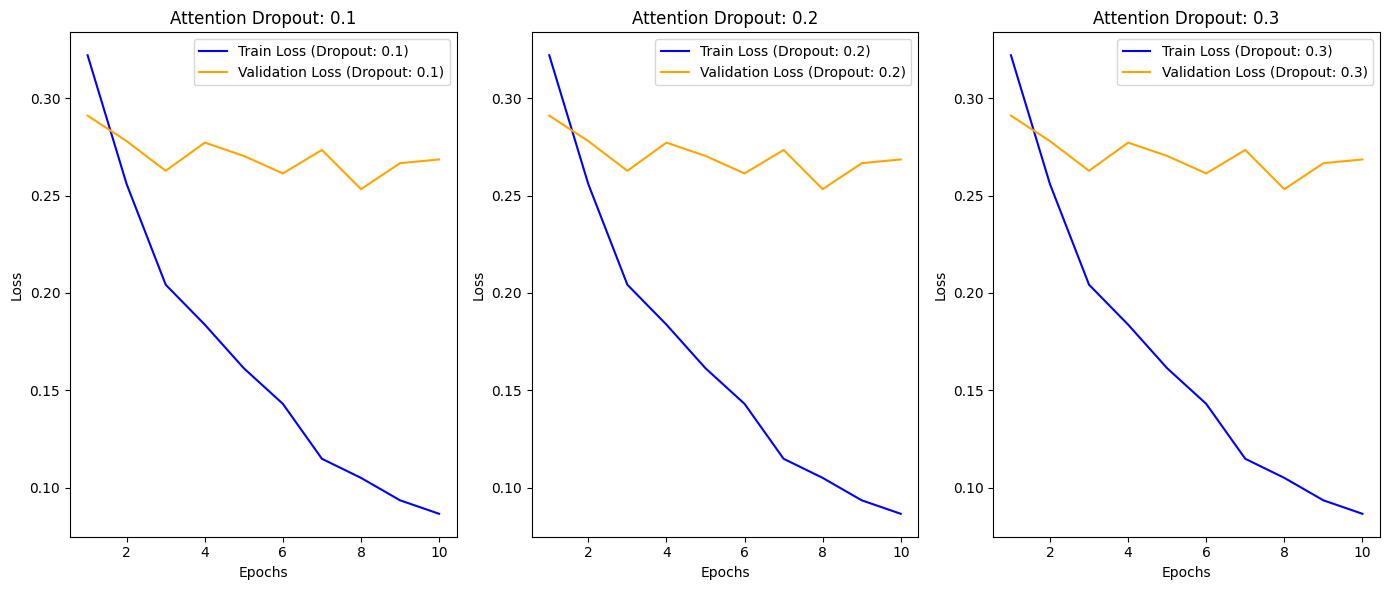


--- Starting Training for Pre_classifier Dropout 0.2 ---

Epoch 1, Train Loss: 0.3221835550424215, Validation Loss: 0.2911547780036926
Epoch 2, Train Loss: 0.255921866039972, Validation Loss: 0.27803908213973044
Epoch 3, Train Loss: 0.20425202677378784, Validation Loss: 0.26279982924461365
Epoch 4, Train Loss: 0.18374609232351585, Validation Loss: 0.27728589847683904
Epoch 5, Train Loss: 0.1613279299156086, Validation Loss: 0.2704495227895677
Epoch 6, Train Loss: 0.14302897453308105, Validation Loss: 0.2614553149789572
Epoch 7, Train Loss: 0.11479120006835139, Validation Loss: 0.27352446051146445
Epoch 8, Train Loss: 0.10498285172758876, Validation Loss: 0.25335957342758775
Epoch 9, Train Loss: 0.093451581140225, Validation Loss: 0.2667168230487732
Epoch 10, Train Loss: 0.08652300644363906, Validation Loss: 0.2686359939572867

--- Starting Training for Pre_classifier Dropout 0.3 ---

Epoch 1, Train Loss: 0.3221835550424215, Validation Loss: 0.2911547780036926
Epoch 2, Train Loss: 0.25

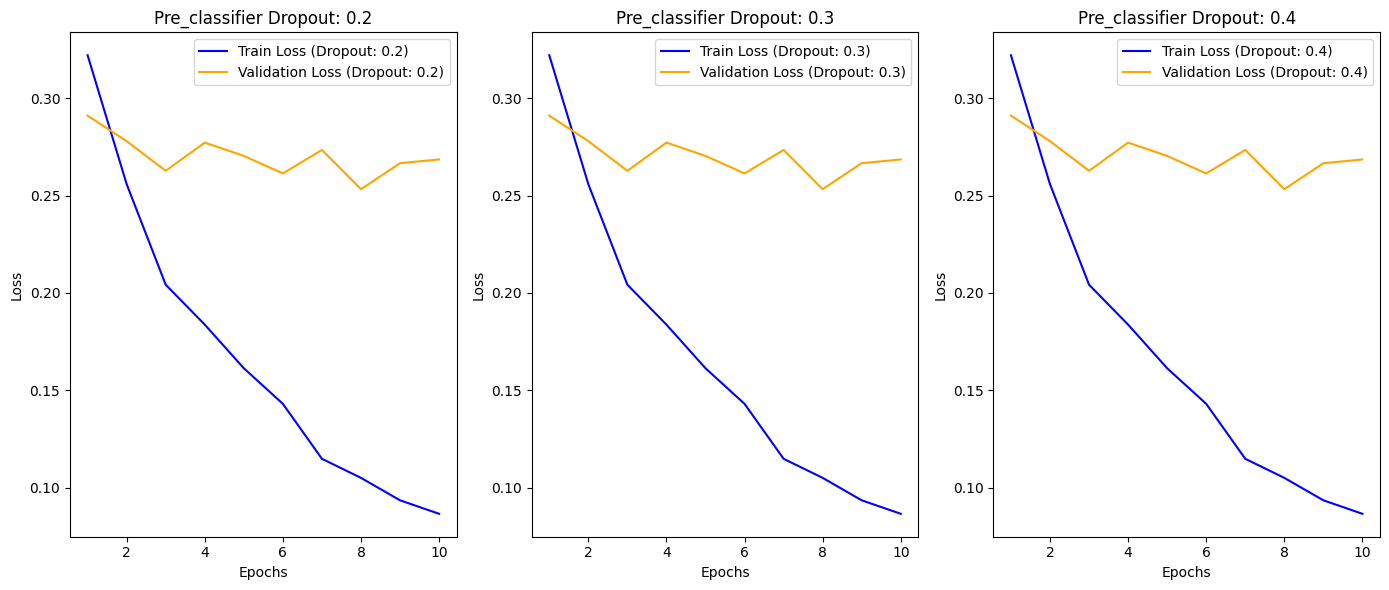

In [21]:
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.nn import MSELoss

# Function to reset the model, train, and return training/validation loss with adjustable dropout for specific layers
def train_model_with_specific_dropout(train_dataloader, val_dataloader, dropout, layer_type, num_epochs=10, patience=5, learning_rate=1e-5):
    # Reset the model
    model = reset_model_and_seed()

    # Adjust the dropout layers based on the specified layer type
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            if layer_type == 'ffn':  # Target FFN dropout
                if hasattr(module, 'in_features') and module.in_features == 3072:  # Feed-Forward Network
                    module.p = dropout
            elif layer_type == 'attention':  # Target Attention dropout
                if hasattr(module, 'q_lin'):  # Multi-Head Attention
                    module.p = dropout
            elif layer_type == 'pre_classifier':  # Target Pre-Classifier dropout
                if hasattr(module, 'out_features') and module.out_features == 1:  # Pre-classifier
                    module.p = dropout

    # Set optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = MSELoss()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience)

    # Lists to track losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        # Print the loss for the current epoch
        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            break

    return train_losses, val_losses


# Function to train and plot for specific layer dropout tuning
def plot_layer_dropout_tuning(layer_type, dropout_values, train_dataloader, val_dataloader):
    train_losses_list = []
    val_losses_list = []

    for dropout in dropout_values:
        print(f"\n--- Starting Training for {layer_type.capitalize()} Dropout {dropout} ---\n")
        train_losses, val_losses = train_model_with_specific_dropout(
            train_dataloader, val_dataloader, dropout=dropout, layer_type=layer_type)
        train_losses_list.append(train_losses)
        val_losses_list.append(val_losses)

    # Plot the results for the current layer type
    epochs = range(1, len(train_losses_list[0]) + 1)
    plt.figure(figsize=(14, 6))

    for i, dropout in enumerate(dropout_values):
        plt.subplot(1, len(dropout_values), i + 1)
        plt.plot(epochs, train_losses_list[i], label=f"Train Loss (Dropout: {dropout})", color='blue')
        plt.plot(epochs, val_losses_list[i], label=f"Validation Loss (Dropout: {dropout})", color='orange')
        plt.title(f"{layer_type.capitalize()} Dropout: {dropout}")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

    plt.tight_layout()
    plt.show()


# Define ranges for each type of dropout
dropout_ffn_values = [0.1, 0.2, 0.3]  # Increasing FFN dropout from 0.1 upwards
dropout_attention_values = [0.1, 0.2, 0.3]  # Increasing Attention dropout from 0.1 upwards
dropout_pre_classifier_values = [0.2, 0.3, 0.4]  # Increasing Pre-Classifier dropout from 0.2 upwards

# 1. Tune and plot Feed-Forward Dropout (FFN)
plot_layer_dropout_tuning(layer_type='ffn', dropout_values=dropout_ffn_values, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

# 2. Tune and plot Attention Dropout
plot_layer_dropout_tuning(layer_type='attention', dropout_values=dropout_attention_values, train_dataloader=train_dataloader, val_dataloader=val_dataloader)

# 3. Tune and plot Pre-Classifier Dropout
plot_layer_dropout_tuning(layer_type='pre_classifier', dropout_values=dropout_pre_classifier_values, train_dataloader=train_dataloader, val_dataloader=val_dataloader)


No significant improvement was seen try adding weight decay

# Adding a weight decay

Training with weight decay: 0.0
Training with weight decay: 0.01
Training with weight decay: 0.05
Training with weight decay: 0.1


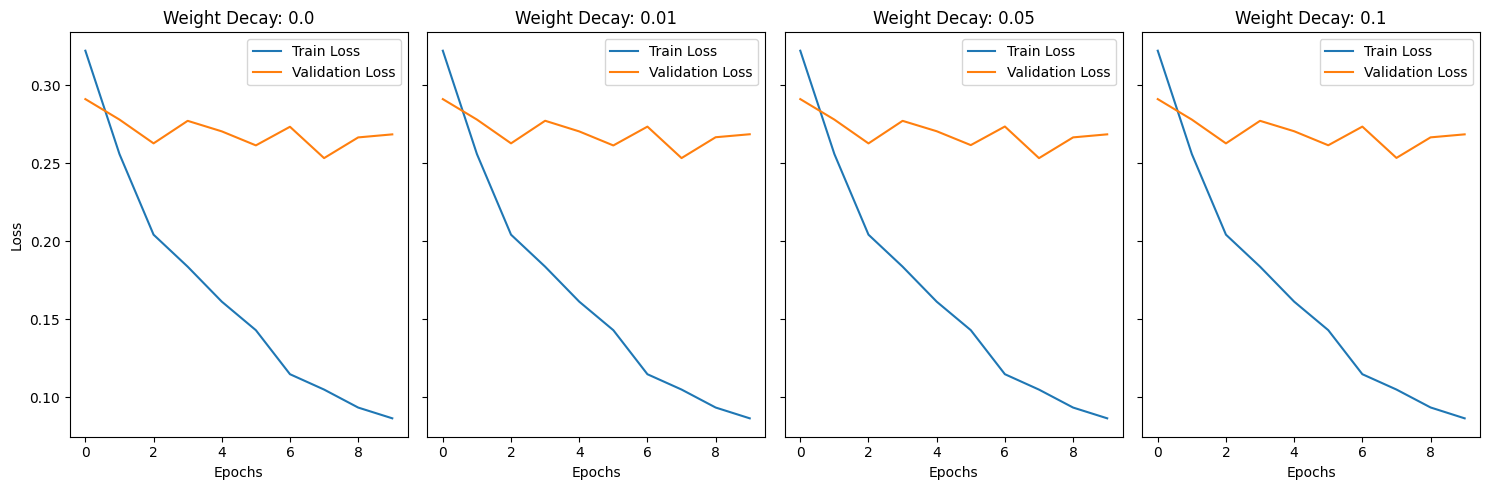

In [23]:
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.nn import MSELoss

# Define a function to train and track loss with different weight decays
def train_model_with_weight_decay(model, train_dataloader, val_dataloader, num_epochs=10, patience=5, learning_rate=1e-5, weight_decay=0.0, model_path='/content/drive/MyDrive/DL_Trump_Files/pretrained_trump_model/'):

    # Reset the model at the start of each training loop
    model = reset_model_and_seed()

    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = MSELoss()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience)

    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    return train_losses, val_losses

# List of weight decay values to experiment with
weight_decay_values = [0.0, 0.01, 0.05, 0.1]

# Train and plot for each weight decay value
fig, axes = plt.subplots(1, len(weight_decay_values), figsize=(15, 5), sharey=True)

model = reset_model_and_seed()

for i, weight_decay in enumerate(weight_decay_values):
    print(f"Training with weight decay: {weight_decay}")

    # Reset the model before each weight decay experiment
    model = reset_model_and_seed()

    # Train the model with the current weight decay value
    train_losses, val_losses = train_model_with_weight_decay(
        model, train_dataloader, val_dataloader, num_epochs=10, weight_decay=weight_decay
    )

    # Plot losses
    axes[i].plot(range(len(train_losses)), train_losses, label="Train Loss")
    axes[i].plot(range(len(val_losses)), val_losses, label="Validation Loss")
    axes[i].set_title(f"Weight Decay: {weight_decay}")
    axes[i].set_xlabel("Epochs")
    if i == 0:
        axes[i].set_ylabel("Loss")
    axes[i].legend()

plt.tight_layout()
plt.show()


Weight decay also did not imporve the overfitting try a combination.


--- Starting Training with Combined Dropout and Weight Decay ---

Epoch 1, Train Loss: 0.3221835550424215, Validation Loss: 0.2911547780036926
Epoch 2, Train Loss: 0.255921866039972, Validation Loss: 0.27803908213973044
Epoch 3, Train Loss: 0.20425202677378784, Validation Loss: 0.26279982924461365
Epoch 4, Train Loss: 0.18374609232351585, Validation Loss: 0.27728589847683904
Epoch 5, Train Loss: 0.1613279299156086, Validation Loss: 0.2704495227895677
Epoch 6, Train Loss: 0.14302897453308105, Validation Loss: 0.2614553149789572
Epoch 7, Train Loss: 0.11479120006835139, Validation Loss: 0.27352446051146445
Epoch 8, Train Loss: 0.10498285172758876, Validation Loss: 0.25335957342758775
Epoch 9, Train Loss: 0.093451581140225, Validation Loss: 0.2667168230487732
Epoch 10, Train Loss: 0.08652300644363906, Validation Loss: 0.2686359939572867


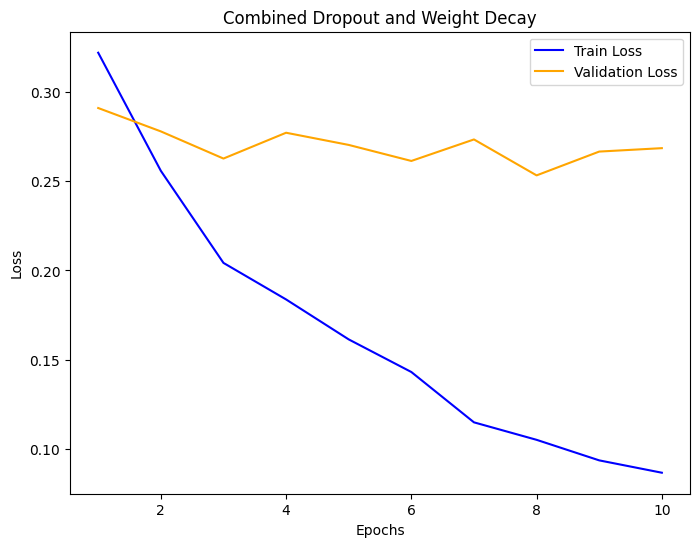

In [24]:
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.nn import MSELoss

# Function to reset the model, train, and return training/validation loss with adjustable dropout and weight decay
def train_model_with_combined_dropout_and_weight_decay(train_dataloader, val_dataloader, ffn_dropout, attention_dropout, pre_classifier_dropout, weight_decay, num_epochs=10, patience=5, learning_rate=1e-5):
    # Reset the model
    model = reset_model_and_seed()

    # Adjust the dropout layers in the model based on their location
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            if 'ffn' in str(module):  # FFN dropout
                module.p = ffn_dropout
            elif 'attention' in str(module):  # Attention dropout
                module.p = attention_dropout
            elif 'pre_classifier' in str(module):  # Pre-Classifier dropout
                module.p = pre_classifier_dropout

    # Set optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = MSELoss()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience)

    # Lists to track losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        # Print the loss for the current epoch
        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            break

    return train_losses, val_losses


# Middle dropout and weight decay values
ffn_dropout = 0.2
attention_dropout = 0.2
pre_classifier_dropout = 0.3
weight_decay = 0.01

# Train and validate with combined dropout and weight decay
print(f"\n--- Starting Training with Combined Dropout and Weight Decay ---\n")
train_losses, val_losses = train_model_with_combined_dropout_and_weight_decay(
    train_dataloader,
    val_dataloader,
    ffn_dropout=ffn_dropout,
    attention_dropout=attention_dropout,
    pre_classifier_dropout=pre_classifier_dropout,
    weight_decay=weight_decay
)

# Plot the results
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label=f"Train Loss", color='blue')
plt.plot(epochs, val_losses, label=f"Validation Loss", color='orange')
plt.title(f"Combined Dropout and Weight Decay")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


This also had no impact implying the issue is elsewhere next try layer freezing

# More Layer freezing

Epoch 1, Train Loss: 0.3221835550424215, Validation Loss: 0.2911547780036926
Epoch 2, Train Loss: 0.255921866039972, Validation Loss: 0.27803908213973044
Epoch 3, Train Loss: 0.20425202677378784, Validation Loss: 0.26279982924461365
Epoch 4, Train Loss: 0.18374609232351585, Validation Loss: 0.27728589847683904
Epoch 5, Train Loss: 0.1613279299156086, Validation Loss: 0.2704495227895677
Epoch 6, Train Loss: 0.14302897453308105, Validation Loss: 0.2614553149789572
Epoch 7, Train Loss: 0.11479120006835139, Validation Loss: 0.27352446051146445
Epoch 8, Train Loss: 0.10498285172758876, Validation Loss: 0.25335957342758775
Epoch 9, Train Loss: 0.093451581140225, Validation Loss: 0.2667168230487732
Epoch 10, Train Loss: 0.08652300644363906, Validation Loss: 0.2686359939572867
Epoch 1, Train Loss: 0.32253365138092555, Validation Loss: 0.29359540045261384
Epoch 2, Train Loss: 0.26406271715421936, Validation Loss: 0.28229579627513884
Epoch 3, Train Loss: 0.2272036607201035, Validation Loss: 0.26

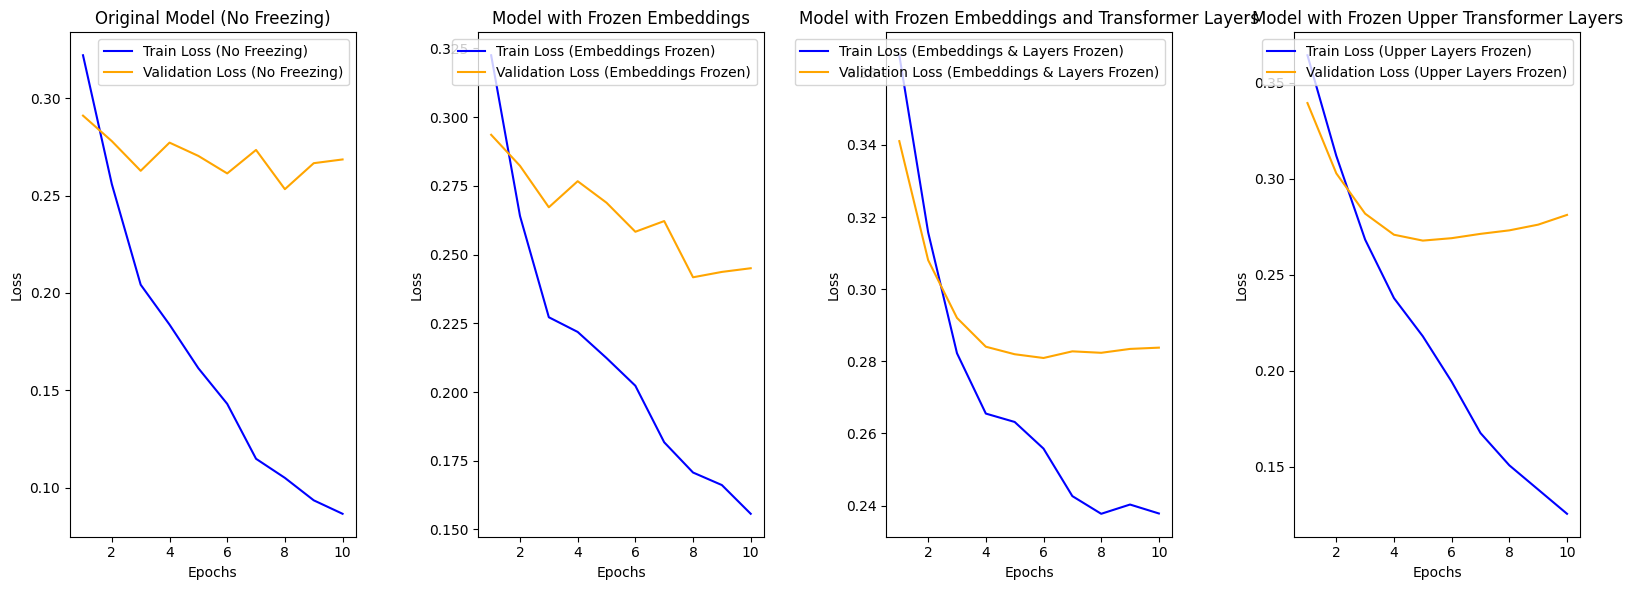

In [25]:
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.nn import MSELoss

# Function to reset the model, train, and return training/validation loss
def train_model_general(train_dataloader, val_dataloader, num_epochs=10, patience=5, learning_rate=1e-5, freeze_embeddings=False, freeze_upper_layers=False):
    # Reset the model
    model = reset_model_and_seed()

    # Apply freezing logic
    if freeze_embeddings:
        # Freeze embeddings
        for param in model.distilbert.embeddings.parameters():
            param.requires_grad = False  # Freeze embeddings

    if freeze_upper_layers:
        # Freeze the upper transformer layers (layers 4 and above)
        for param in model.distilbert.transformer.layer[4:].parameters():
            param.requires_grad = False

    # Ensure the pre-classifier and classifier layers are trainable
    for param in model.pre_classifier.parameters():
        param.requires_grad = True  # Ensure pre-classifier is trainable

    for param in model.classifier.parameters():
        param.requires_grad = True  # Ensure classifier is trainable

    # Set optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = MSELoss()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience)

    # Lists to track losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Average training loss
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

        # Check for early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Return the training and validation losses
    return train_losses, val_losses

# Call the model training with different freezing levels
# 1. No freezing
train_losses_original, val_losses_original = train_model_general(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=10,
    patience=5,
    learning_rate=1e-5,
    freeze_embeddings=False,
    freeze_upper_layers=False
)

# 2. Freeze embeddings only
train_losses_freeze_embeddings, val_losses_freeze_embeddings = train_model_general(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=10,
    patience=5,
    learning_rate=1e-5,
    freeze_embeddings=True,
    freeze_upper_layers=False
)

# 3. Freeze embeddings and upper transformer layers
train_losses_freeze_all, val_losses_freeze_all = train_model_general(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=10,
    patience=5,
    learning_rate=1e-5,
    freeze_embeddings=True,
    freeze_upper_layers=True
)

# 4. Freeze upper transformer layers only
train_losses_freeze_upper, val_losses_freeze_upper = train_model_general(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=10,
    patience=5,
    learning_rate=1e-5,
    freeze_embeddings=False,
    freeze_upper_layers=True
)

# Plot the training and validation losses side by side for comparison
epochs_original = range(1, len(train_losses_original) + 1)
epochs_freeze_embeddings = range(1, len(train_losses_freeze_embeddings) + 1)
epochs_freeze_all = range(1, len(train_losses_freeze_all) + 1)
epochs_freeze_upper = range(1, len(train_losses_freeze_upper) + 1)

plt.figure(figsize=(16, 6))

# Plot for the original model (no freezing)
plt.subplot(1, 4, 1)
plt.plot(epochs_original, train_losses_original, label="Train Loss (No Freezing)", color='blue')
plt.plot(epochs_original, val_losses_original, label="Validation Loss (No Freezing)", color='orange')
plt.title("Original Model (No Freezing)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot for the model with frozen embeddings
plt.subplot(1, 4, 2)
plt.plot(epochs_freeze_embeddings, train_losses_freeze_embeddings, label="Train Loss (Embeddings Frozen)", color='blue')
plt.plot(epochs_freeze_embeddings, val_losses_freeze_embeddings, label="Validation Loss (Embeddings Frozen)", color='orange')
plt.title("Model with Frozen Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot for the model with frozen embeddings and upper transformer layers
plt.subplot(1, 4, 3)
plt.plot(epochs_freeze_all, train_losses_freeze_all, label="Train Loss (Embeddings & Layers Frozen)", color='blue')
plt.plot(epochs_freeze_all, val_losses_freeze_all, label="Validation Loss (Embeddings & Layers Frozen)", color='orange')
plt.title("Model with Frozen Embeddings and Transformer Layers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot for the model with only frozen upper layers
plt.subplot(1, 4, 4)
plt.plot(epochs_freeze_upper, train_losses_freeze_upper, label="Train Loss (Upper Layers Frozen)", color='blue')
plt.plot(epochs_freeze_upper, val_losses_freeze_upper, label="Validation Loss (Upper Layers Frozen)", color='orange')
plt.title("Model with Frozen Upper Transformer Layers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


Starting training for: Original Model (No Freezing)
Epoch 1/10 for Original Model (No Freezing)
Original Model (No Freezing) - Epoch 1, Train Loss: 0.3221835550424215, Validation Loss: 0.2911547780036926
Epoch 2/10 for Original Model (No Freezing)
Original Model (No Freezing) - Epoch 2, Train Loss: 0.255921866039972, Validation Loss: 0.27803908213973044
Epoch 3/10 for Original Model (No Freezing)
Original Model (No Freezing) - Epoch 3, Train Loss: 0.20425202677378784, Validation Loss: 0.26279982924461365
Epoch 4/10 for Original Model (No Freezing)
Original Model (No Freezing) - Epoch 4, Train Loss: 0.18374609232351585, Validation Loss: 0.27728589847683904
Epoch 5/10 for Original Model (No Freezing)
Original Model (No Freezing) - Epoch 5, Train Loss: 0.1613279299156086, Validation Loss: 0.2704495227895677
Epoch 6/10 for Original Model (No Freezing)
Original Model (No Freezing) - Epoch 6, Train Loss: 0.14302897453308105, Validation Loss: 0.2614553149789572
Epoch 7/10 for Original Model (

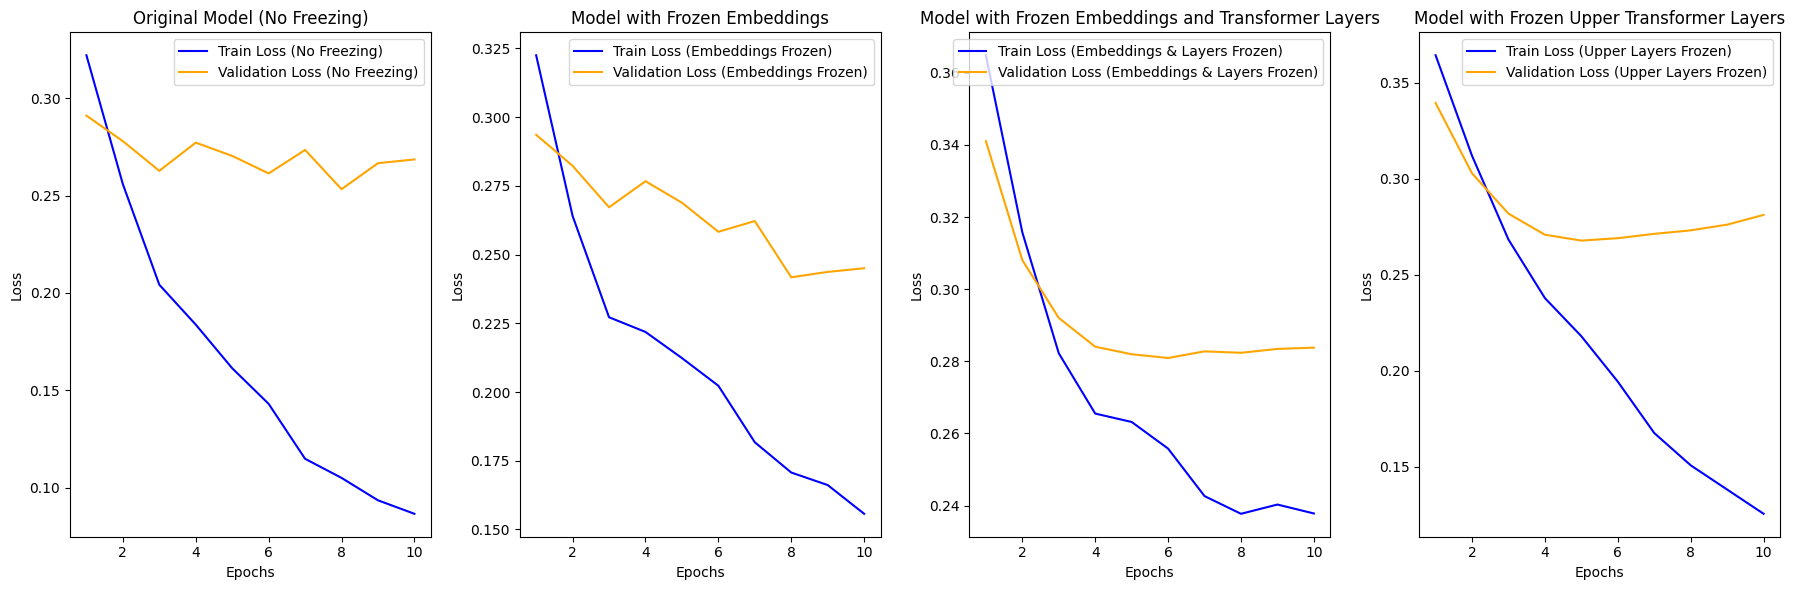

In [28]:
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.nn import MSELoss

# Function to reset the model, train, and return training/validation loss
def train_model_general(train_dataloader, val_dataloader, num_epochs=10, patience=5, learning_rate=1e-5, freeze_embeddings=False, freeze_upper_layers=False, stage_desc=""):
    # Reset the model
    print(f"Starting training for: {stage_desc}")
    model = reset_model_and_seed()

    # Apply freezing logic
    if freeze_embeddings:
        # Freeze embeddings
        print(f"Freezing embeddings for: {stage_desc}")
        for param in model.distilbert.embeddings.parameters():
            param.requires_grad = False  # Freeze embeddings

    if freeze_upper_layers:
        # Freeze the upper transformer layers (layers 4 and above)
        print(f"Freezing upper transformer layers for: {stage_desc}")
        for param in model.distilbert.transformer.layer[4:].parameters():
            param.requires_grad = False

    # Ensure the pre-classifier and classifier layers are trainable
    for param in model.pre_classifier.parameters():
        param.requires_grad = True  # Ensure pre-classifier is trainable

    for param in model.classifier.parameters():
        param.requires_grad = True  # Ensure classifier is trainable

    # Set optimizer and loss function
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = MSELoss()

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience)

    # Lists to track losses
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs} for {stage_desc}")
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Average training loss
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = criterion(outputs.logits, labels)
                val_loss += loss.item()

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        print(f"{stage_desc} - Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

        # Check for early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping for {stage_desc} at epoch {epoch + 1}")
            break

    # Return the training and validation losses
    return train_losses, val_losses

# Call the model training with different freezing levels
# 1. No freezing
train_losses_original, val_losses_original = train_model_general(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=10,
    patience=5,
    learning_rate=1e-5,
    freeze_embeddings=False,
    freeze_upper_layers=False,
    stage_desc="Original Model (No Freezing)"
)

# 2. Freeze embeddings only
train_losses_freeze_embeddings, val_losses_freeze_embeddings = train_model_general(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=10,
    patience=5,
    learning_rate=1e-5,
    freeze_embeddings=True,
    freeze_upper_layers=False,
    stage_desc="Model with Frozen Embeddings"
)

# 3. Freeze embeddings and upper transformer layers
train_losses_freeze_all, val_losses_freeze_all = train_model_general(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=10,
    patience=5,
    learning_rate=1e-5,
    freeze_embeddings=True,
    freeze_upper_layers=True,
    stage_desc="Model with Frozen Embeddings and Transformer Layers"
)

# 4. Freeze upper transformer layers only
train_losses_freeze_upper, val_losses_freeze_upper = train_model_general(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    num_epochs=10,
    patience=5,
    learning_rate=1e-5,
    freeze_embeddings=False,
    freeze_upper_layers=True,
    stage_desc="Model with Frozen Upper Transformer Layers"
)

# Plot the training and validation losses side by side for comparison
epochs_original = range(1, len(train_losses_original) + 1)
epochs_freeze_embeddings = range(1, len(train_losses_freeze_embeddings) + 1)
epochs_freeze_all = range(1, len(train_losses_freeze_all) + 1)
epochs_freeze_upper = range(1, len(train_losses_freeze_upper) + 1)

plt.figure(figsize=(18, 6))

# Plot for the original model (no freezing)
plt.subplot(1, 4, 1)
plt.plot(epochs_original, train_losses_original, label="Train Loss (No Freezing)", color='blue')
plt.plot(epochs_original, val_losses_original, label="Validation Loss (No Freezing)", color='orange')
plt.title("Original Model (No Freezing)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot for the model with frozen embeddings
plt.subplot(1, 4, 2)
plt.plot(epochs_freeze_embeddings, train_losses_freeze_embeddings, label="Train Loss (Embeddings Frozen)", color='blue')
plt.plot(epochs_freeze_embeddings, val_losses_freeze_embeddings, label="Validation Loss (Embeddings Frozen)", color='orange')
plt.title("Model with Frozen Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot for the model with frozen embeddings and upper transformer layers
plt.subplot(1, 4, 3)
plt.plot(epochs_freeze_all, train_losses_freeze_all, label="Train Loss (Embeddings & Layers Frozen)", color='blue')
plt.plot(epochs_freeze_all, val_losses_freeze_all, label="Validation Loss (Embeddings & Layers Frozen)", color='orange')
plt.title("Model with Frozen Embeddings and Transformer Layers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot for the model with only frozen upper layers
plt.subplot(1, 4, 4)
plt.plot(epochs_freeze_upper, train_losses_freeze_upper, label="Train Loss (Upper Layers Frozen)", color='blue')
plt.plot(epochs_freeze_upper, val_losses_freeze_upper, label="Validation Loss (Upper Layers Frozen)", color='orange')
plt.title("Model with Frozen Upper Transformer Layers")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


Pick option 3 since it overfits less and the validation and training loss are more close

In [ ]:
# Freezing embeddings makes the model overfit less which is good. We also don't want to move too close to validation Loss since the validation is not extremely accurate. Therefore This is good as it will get for overfitting.

# New reset function (resets to correct freeze)

In [ ]:
# Function to reset the model, set a random seed, and freeze specific layers
def reset_model_and_seed_embeddings_and_transformer_frozen(model_path='/content/drive/MyDrive/DL_Trump_Files/pretrained_trump_model/', seed=0):
    # Set the seed for reproducibility
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Reload the pre-trained model from the provided path
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        num_labels=1,  # This is for regression
        ignore_mismatched_sizes=True  # Ignore the classifier size mismatch
    ).to(device)

    # Freezing layers
    # Freeze embeddings
    for param in model.distilbert.embeddings.parameters():
        param.requires_grad = False  # Freeze embeddings

    # Freeze all transformer layers (layers 0 to 5)
    for layer in model.distilbert.transformer.layer[:6]:  # Freeze all transformer layers (0-5)
        for param in layer.parameters():
            param.requires_grad = False  # Freeze these layers

    # Make sure the classifier layers are trainable
    for param in model.pre_classifier.parameters():
        param.requires_grad = True  # Ensure pre-classifier is trainable

    for param in model.classifier.parameters():
        param.requires_grad = True  # Ensure classifier is trainable

    return model


In [ ]:
# Looking at the graph on the far left it appears that this rate is slightly slower in reducing the loss compared to the other learning rates. The validation loss decreases steadily,
# but the training loss shows a slower descent compared to the higher learning rates it's clear that the learning rate is a bit too conservative.

In [ ]:
# The CyclicLR scheduler creates a learning rate cycle that moves between the base and maximum values.
# This is beneficial for helping the model escape sharp local minima during optimization, promoting better generalization.

# So when the learning rate is 1 its going to 1e^-5 and thats why its at the top
# and it steadily increases from 1e^-6 to 1e^-5 and when it hits 1e5 it drops down to 1e6

# Attempt a cyclic learning rate to find the best range for learning rate and add gradient clipping to prevent gradient explosion

Epoch 1/10, Train Loss: 0.3846606451111871, Validation Loss: 0.36364899277687074
Epoch 2/10, Train Loss: 0.3443736911222741, Validation Loss: 0.33491694927215576
Epoch 3/10, Train Loss: 0.3135443410357913, Validation Loss: 0.31521938741207123
Epoch 4/10, Train Loss: 0.29037589881871195, Validation Loss: 0.30148751139640806
Epoch 5/10, Train Loss: 0.28439086232636424, Validation Loss: 0.2946400552988052
Epoch 6/10, Train Loss: 0.27129739724301005, Validation Loss: 0.28873254358768463
Epoch 7/10, Train Loss: 0.2573447410722037, Validation Loss: 0.28534927070140836
Epoch 8/10, Train Loss: 0.24755839479936137, Validation Loss: 0.2841753736138344
Epoch 9/10, Train Loss: 0.2483306898659951, Validation Loss: 0.28451309353113174
Epoch 10/10, Train Loss: 0.24433861632604856, Validation Loss: 0.28547664135694506
Epoch 1/10, Train Loss: 0.4050357619652877, Validation Loss: 0.39942203760147094
Epoch 2/10, Train Loss: 0.3994533733741657, Validation Loss: 0.3948324143886566
Epoch 3/10, Train Loss: 0

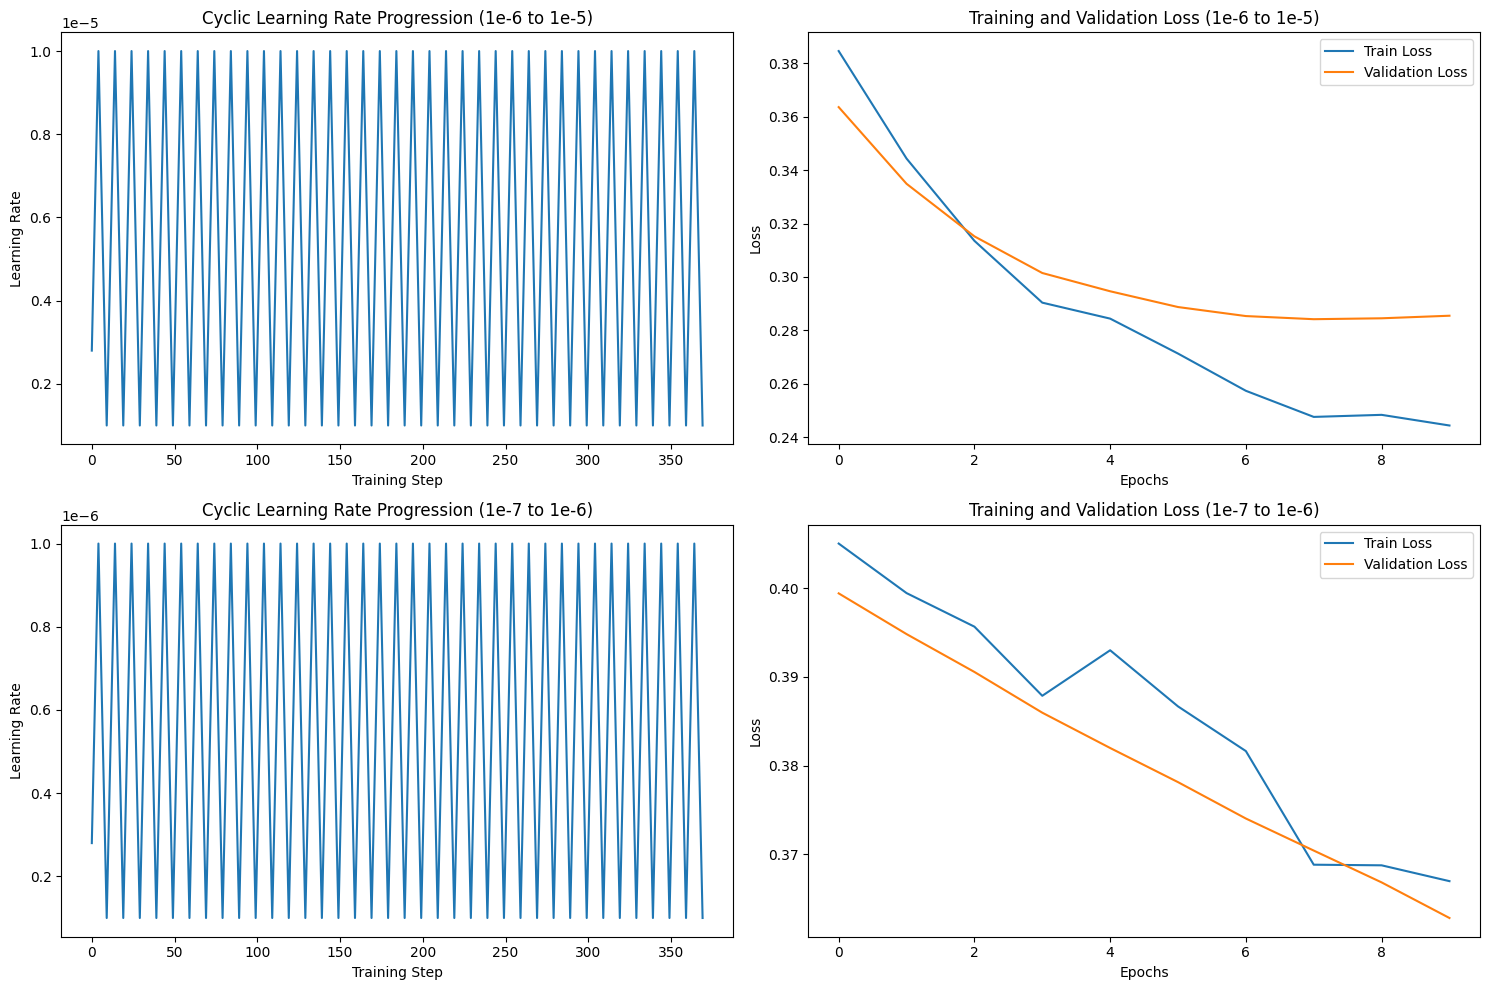

In [36]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CyclicLR
from torch.nn import MSELoss
import numpy as np
import matplotlib.pyplot as plt

# Function to reset the model, set seed, and freeze embeddings & transformer layers (option 3)
def reset_model_and_seed_embeddings_and_transformer_frozen(model_path='/content/drive/MyDrive/DL_Trump_Files/pretrained_trump_model/', seed=0):
    # Set the seed for reproducibility
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    # Reload the pre-trained model from the provided path
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path,
        num_labels=1,  # This is for regression
        ignore_mismatched_sizes=True  # Ignore the classifier size mismatch
    ).to(device)

    # Freeze embeddings
    for param in model.distilbert.embeddings.parameters():
        param.requires_grad = False  # Freeze embeddings

    # Freeze all transformer layers (layers 0 to 5)
    for layer in model.distilbert.transformer.layer[:6]:
        for param in layer.parameters():
            param.requires_grad = False  # Freeze layers

    # Ensure the classifier layers are trainable
    for param in model.pre_classifier.parameters():
        param.requires_grad = True  # Ensure pre-classifier is trainable

    for param in model.classifier.parameters():
        param.requires_grad = True  # Ensure classifier is trainable

    return model

# Function for training with cyclic learning rates and gradient clipping
def train_with_cyclic_lr(model, train_dataloader, val_dataloader, base_lr, max_lr, step_size_up, num_epochs=10, max_grad_norm=1.0):
    optimizer = AdamW(model.parameters(), lr=base_lr)
    scheduler = CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=step_size_up, mode='triangular')
    criterion = MSELoss()

    train_losses = []
    val_losses = []
    lr_values = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()

            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()

            # Step the scheduler
            scheduler.step()
            lr_values.append(scheduler.get_last_lr()[0])
            running_train_loss += loss.item()

        train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                val_loss = criterion(outputs.logits, labels)
                running_val_loss += val_loss.item()

        val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    return lr_values, train_losses, val_losses

# Example learning rates to test
base_lr = 1e-6
max_lr = 1e-5
step_size_up = 5  # Can adjust based on dataset size

# Reset and run the first experiment
model = reset_model_and_seed_embeddings_and_transformer_frozen()
lr_values1, train_losses1, val_losses1 = train_with_cyclic_lr(model, train_dataloader, val_dataloader, base_lr, max_lr, step_size_up)

# Reset and run a second experiment with a different learning rate range
base_lr2 = 1e-7
max_lr2 = 1e-6
model = reset_model_and_seed_embeddings_and_transformer_frozen()
lr_values2, train_losses2, val_losses2 = train_with_cyclic_lr(model, train_dataloader, val_dataloader, base_lr2, max_lr2, step_size_up)

# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot first learning rate range
axes[0, 0].plot(lr_values1)
axes[0, 0].set_title("Cyclic Learning Rate Progression (1e-6 to 1e-5)")
axes[0, 0].set_xlabel("Training Step")
axes[0, 0].set_ylabel("Learning Rate")

axes[0, 1].plot(range(len(train_losses1)), train_losses1, label="Train Loss")
axes[0, 1].plot(range(len(val_losses1)), val_losses1, label="Validation Loss")
axes[0, 1].set_title("Training and Validation Loss (1e-6 to 1e-5)")
axes[0, 1].set_xlabel("Epochs")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].legend()

# Plot second learning rate range
axes[1, 0].plot(lr_values2)
axes[1, 0].set_title("Cyclic Learning Rate Progression (1e-7 to 1e-6)")
axes[1, 0].set_xlabel("Training Step")
axes[1, 0].set_ylabel("Learning Rate")

axes[1, 1].plot(range(len(train_losses2)), train_losses2, label="Train Loss")
axes[1, 1].plot(range(len(val_losses2)), val_losses2, label="Validation Loss")
axes[1, 1].set_title("Training and Validation Loss (1e-7 to 1e-6)")
axes[1, 1].set_xlabel("Epochs")
axes[1, 1].set_ylabel("Loss")
axes[1, 1].legend()

plt.tight_layout()
plt.show()


It seems that a learning rate between 1e-7 and 1e-6 is a better choice having a steady decresase in validation loss amd also a decrease in training loss

Epoch 1/10, Learning Rate: 1e-07, Train Loss: 0.4070314193094099, Validation Loss: 0.40324283838272096
Epoch 2/10, Learning Rate: 1e-07, Train Loss: 0.4059855692289971, Validation Loss: 0.40234055519104006
Epoch 3/10, Learning Rate: 1e-07, Train Loss: 0.4068561147999119, Validation Loss: 0.4015057861804962
Epoch 4/10, Learning Rate: 1e-07, Train Loss: 0.40335047526939494, Validation Loss: 0.4006067872047424
Epoch 5/10, Learning Rate: 1e-07, Train Loss: 0.412490851573042, Validation Loss: 0.3997367203235626
Epoch 6/10, Learning Rate: 1e-07, Train Loss: 0.41075385583413615, Validation Loss: 0.39891029596328736
Epoch 7/10, Learning Rate: 1e-07, Train Loss: 0.40954237813885147, Validation Loss: 0.3980501353740692
Epoch 8/10, Learning Rate: 1e-07, Train Loss: 0.40028787142521627, Validation Loss: 0.39723106026649474
Epoch 9/10, Learning Rate: 1e-07, Train Loss: 0.4038596278106844, Validation Loss: 0.39635257720947265
Epoch 10/10, Learning Rate: 1e-07, Train Loss: 0.4058417412074837, Validat

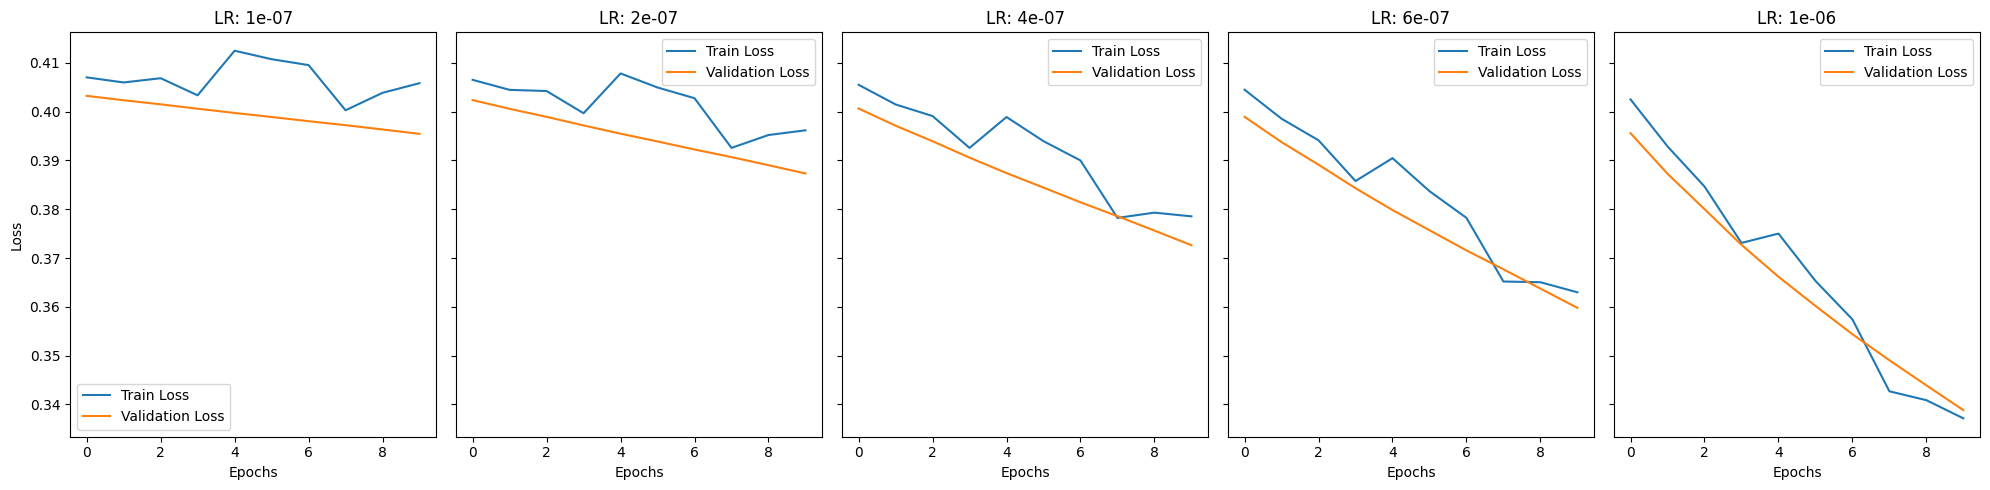

In [40]:
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.nn import MSELoss

# Define learning rates to test
learning_rates = [1e-7, 2e-7, 4e-7, 6e-7, 1e-6]

# Initialize lists to store losses for each learning rate
all_train_losses = []
all_val_losses = []

# Iterate through each learning rate
for lr in learning_rates:
    # Reset the model
    model = reset_model_and_seed_embeddings_and_transformer_frozen()

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.0)

    # Define loss function
    criterion = MSELoss()

    # Lists to track losses for this learning rate
    train_losses = []
    val_losses = []

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_train_loss += loss.item()

        # Average training loss for the epoch
        train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss = criterion(outputs.logits, labels)
                running_val_loss += val_loss.item()

        # Average validation loss for the epoch
        val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Learning Rate: {lr}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

    # Store losses for this learning rate
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

# Plotting the results for each learning rate
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

for i, lr in enumerate(learning_rates):
    axes[i].plot(range(num_epochs), all_train_losses[i], label="Train Loss")
    axes[i].plot(range(num_epochs), all_val_losses[i], label="Validation Loss")
    axes[i].set_title(f"LR: {lr}")
    axes[i].set_xlabel("Epochs")
    if i == 0:
        axes[i].set_ylabel("Loss")
    axes[i].legend()

plt.tight_layout()
plt.show()


No significant difference 1e-6 might have a too steep decline so just pick the middel option 4e-7

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/DL_Trump_Files/pretrained_trump_model/ and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([1]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([1, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Train Loss: 0.40158247826872645, Validation Loss: 0.3939902544021606
Epoch 2, Train Loss: 0.39085000270121806, Validation Loss: 0.38510716557502744
Epoch 3, Train Loss: 0.3816543990695799, Validation Loss: 0.37706735730171204
Epoch 4, Train Loss: 0.36967649975338496, Validation Loss: 0.36954731941223146
Epoch 5, Train Loss: 0.3719409329665674, Validation Loss: 0.36265574097633363
Epoch 6, Train Loss: 0.3623636763643574, Validation Loss: 0.3565120160579681
Epoch 7, Train Loss: 0.35443970319387075, Validation Loss: 0.35021780133247377
Epoch 8, Train Loss: 0.33854592531114014, Validation Loss: 0.34498525559902193
Epoch 9, Train Loss: 0.33831791700543584, Validation Loss: 0.3400657057762146
Epoch 10, Train Loss: 0.3352697483591131, Validation Loss: 0.3353192627429962


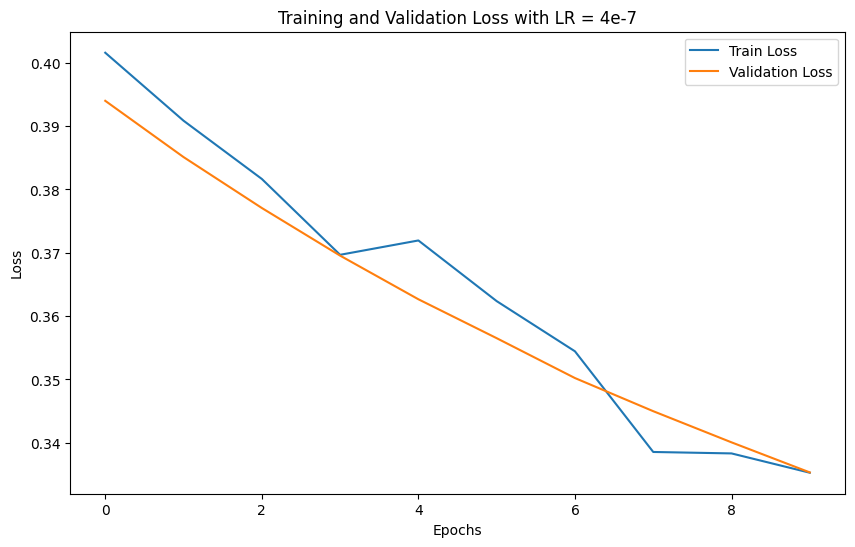

Training Initial Model
Epoch 1/10, LR: 1e-05, Train Loss: 0.3221832928625313, Val Loss: 0.29115397334098814
Epoch 2/10, LR: 1e-05, Train Loss: 0.2559212254914078, Val Loss: 0.2780393473803997
Epoch 3/10, LR: 1e-05, Train Loss: 0.2042513374943991, Val Loss: 0.26279778257012365
Epoch 4/10, LR: 1e-05, Train Loss: 0.1837391463687291, Val Loss: 0.2772344689816236
Epoch 5/10, LR: 1e-05, Train Loss: 0.16133988145235423, Val Loss: 0.2704874758608639
Epoch 6/10, LR: 1e-05, Train Loss: 0.14302478106440725, Val Loss: 0.26150066452100873
Epoch 7/10, LR: 1e-05, Train Loss: 0.11481197002167637, Val Loss: 0.2734291778405641
Epoch 8/10, LR: 1e-05, Train Loss: 0.10496305850510662, Val Loss: 0.25334248384460806
Epoch 9/10, LR: 1e-05, Train Loss: 0.09343034356228404, Val Loss: 0.26660805601713944
Epoch 10/10, LR: 1e-05, Train Loss: 0.0865355474320618, Val Loss: 0.26855544215650295

Training Final Model with LR=4e-7, weight decay, and gradient clipping
Epoch 1/10, LR: 4e-07, Train Loss: 0.4055051481401598

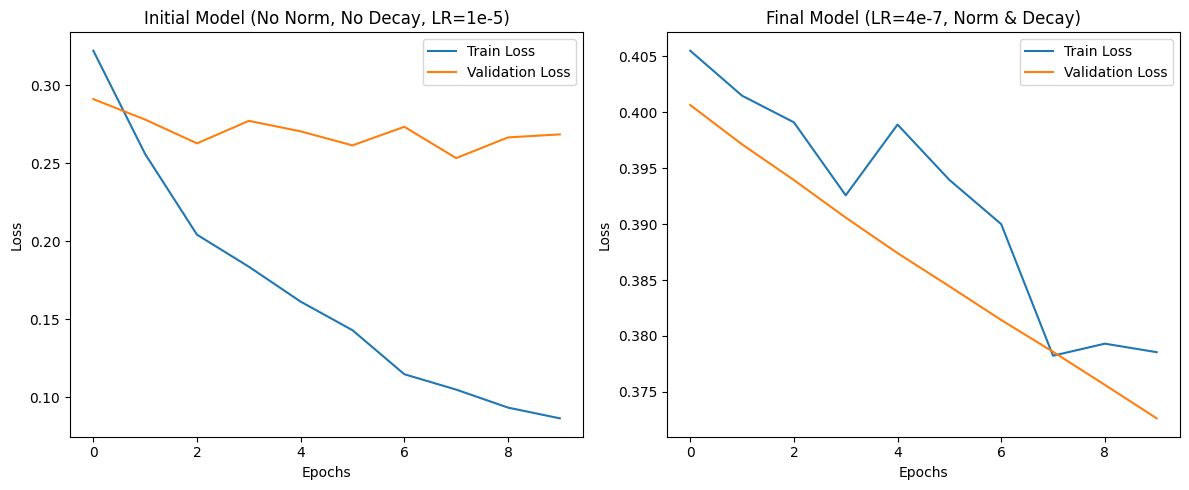

In [42]:
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.nn import MSELoss

def train_model(model, learning_rate, num_epochs=10, weight_decay=0.0, use_norm=False):
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for batch in train_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].unsqueeze(1).to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()

            # Apply gradient clipping if use_norm is True
            if use_norm:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            running_train_loss += loss.item()

        # Average training loss for the epoch
        train_loss = running_train_loss / len(train_dataloader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].unsqueeze(1).to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss = criterion(outputs.logits, labels)
                running_val_loss += val_loss.item()

        # Average validation loss for the epoch
        val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, LR: {learning_rate}, Train Loss: {train_loss}, Val Loss: {val_loss}")

    return train_losses, val_losses

# Train Initial Model (no weight decay, no gradient clipping)
print("Training Initial Model")
initial_model = reset_model_and_seed()
initial_train_losses, initial_val_losses = train_model(
    initial_model, learning_rate=1e-5, num_epochs=10, weight_decay=0.0, use_norm=False
)

# Train Final Model (learning rate of 4e-7, with weight decay and gradient clipping)
print("\nTraining Final Model with LR=4e-7, weight decay, and gradient clipping")
final_model = reset_model_and_seed_embeddings_and_transformer_frozen()
final_train_losses, final_val_losses = train_model(
    final_model, learning_rate=4e-7, num_epochs=10, weight_decay=0.0, use_norm=True
)

# Plotting side-by-side comparison of initial and final model
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for the initial model
axes[0].plot(range(10), initial_train_losses, label="Train Loss")
axes[0].plot(range(10), initial_val_losses, label="Validation Loss")
axes[0].set_title("Initial Model (LR=1e-5)")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Plot for the final model
axes[1].plot(range(10), final_train_losses, label="Train Loss")
axes[1].plot(range(10), final_val_losses, label="Validation Loss")
axes[1].set_title("Final Model (LR=4e-7, Norm & Decay)")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

plt.tight_layout()
plt.show()


Altough the final model has worse performance metrics, this is acceptable since the pattern of the final model shows less overfitting which is more important, and the reference data is not necessarily accurate, so focusing on the shape of the loss curves rather than the performance is more important

##Rough evaluation

In [46]:
final_model.eval()

# Disable gradient computation for evaluation
with torch.no_grad():
    for index, row in df_test.iterrows():
        # Tokenize the article text
        inputs = tokenizer(
            row['article'],
            max_length=128,
            padding=True,
            truncation=True,
            return_tensors="pt"
        )

        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        true_label = torch.tensor(row['score'], dtype=torch.float).to(device)  # Get the true score

        # Get model prediction
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_score = output.logits.item()  # Get the model's prediction

        # Store the article, predicted score, and true score
        print(f"Article: {row['article'][:100]}...")  # Truncated for readability
        print(f"Model Prediction: {round(predicted_score, 4)}, Actual Score: {round(true_label.item(), 4)}")
        print("-" * 80)


Article: speech economy policy watch former president headed georgia today speech economy savannah day new ec...
Model Prediction: -0.0276, Actual Score: -0.2951
--------------------------------------------------------------------------------
Article: texas jury clear train driver civil trial bidenharris bus encounter nadia lathanassociated press nad...
Model Prediction: 0.0095, Actual Score: 0.0
--------------------------------------------------------------------------------
Article: excardinals kicker jay feely endorses better job bidenharris former nfl kicker jay feely endorsed pr...
Model Prediction: 0.1168, Actual Score: 0.5215
--------------------------------------------------------------------------------
Article: warnock wont significant number black men voting senator raphael warnock dga said sunday cnns state ...
Model Prediction: -0.0416, Actual Score: -0.2897
--------------------------------------------------------------------------------
Article: rhetoric roulette real hum

##This final model looks acceptable, there is room for improvement, but in general the sign is correct.